In [97]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt

# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils, info_theoretic_measures
importlib.reload(utils)
importlib.reload(dataset_utils)
importlib.reload(info_theoretic_measures)
from utils import *
from dataset_utils import *
from info_theoretic_measures import *

from transformers import pipeline

In [2]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
#model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# model_name = "huggyllama/llama-7b"
# load tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.padding_side = "left"
tokenizer.pad_token_id = tokenizer.eos_token_id

device: cuda


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [44]:
data = {}
data['sentences'] = [
    'Repeat the following letter: \'X\'',
    'Say \'X\''
    ]
data['counter_sentences'] = [
    'While thinking about \'Y\', repeat the following letter: \'X\'',
    'Think \'Y\' but say \'X\''
    ]


In [91]:
def generate_output(model, tokenizer, input_text, max_new_tokens=1, ):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=False)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False, pad_token_id=tokenizer.eos_token_id)
    attention_mask = torch.where(outputs!=tokenizer.eos_token_id, 1, 0).long()
    outputs = {'input_ids': outputs, 'attention_mask': attention_mask}
    return outputs, tokenizer.batch_decode(outputs['input_ids'], skip_special_tokens=True)

In [92]:
max_new_tokens = 5

# format input with the chat template
format_input = "<|system|>\nBe brief when following the user's instructions.</s>\n<|user|>\n{}</s>\n<|assistant|>\n" 
inputs = [format_input.format(sentence) for sentence in data['sentences']]

data['outputs'], data['decoded_outputs'] = generate_output(model, tokenizer, inputs, max_new_tokens=max_new_tokens)
for o in data['decoded_outputs']:
    print(o)
    print('-'*30)

inputs = [format_input.format(sentence) for sentence in data['counter_sentences']]
data['counter_outputs'], data['counter_decoded_outputs'] = generate_output(model, tokenizer, inputs, max_new_tokens=max_new_tokens)
for o in data['counter_decoded_outputs']:
    print(o)
    print('-'*30)

<|system|>
Be brief when following the user's instructions. 
<|user|>
Repeat the following letter: 'X' 
<|assistant|>
X X X X X
------------------------------
<|system|>
Be brief when following the user's instructions. 
<|user|>
Say 'X' 
<|assistant|>
(Makes an "
------------------------------
<|system|>
Be brief when following the user's instructions. 
<|user|>
While thinking about 'Y', repeat the following letter: 'X' 
<|assistant|>
X X X X X
------------------------------
<|system|>
Be brief when following the user's instructions. 
<|user|>
Think 'Y' but say 'X' 
<|assistant|>
In some cases, instead
------------------------------


In [93]:
# get hidden states
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
# specify token positions for which you want the hidden states
token_positions = range(-max_new_tokens-1, 0, 1)
batch_size=64
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
data['hidden_states'] = get_hidden_from_tokens(model, module_names, data['outputs'], batch_size=batch_size, token_position=token_positions)
data['counter_hidden_states'] = get_hidden_from_tokens(model, module_names, data['counter_outputs'], batch_size=batch_size, token_position=token_positions)

100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


In [94]:
data['hidden_states'].shape

torch.Size([32, 2, 6, 4096])

In [129]:
def get_top_k_prob(model, tokenizer, hidden_states, k=5, source_token_pos = 0):
    top_k_tokens = torch.topk(unembed(model, hidden_states[-1, :, source_token_pos]), k, dim=-1)
    top_k_prob = []
    for i in range(k):
        top_k_prob.append(get_probability(model, hidden_states[:,:,source_token_pos], target_token=top_k_tokens.indices[:,i]).numpy())
    top_k_tokens = [[tokenizer.decode(t) for t in tokens] for tokens in top_k_tokens.indices]
    return top_k_tokens, np.array(top_k_prob)

def plot_top_k_prob(probs, counter_probs,selected_layers, k, title=''):
    width = 0.4

    fig, axs = plt.subplots(1, len(selected_layers), figsize=(15, 5))

    for i, l in enumerate(selected_layers):
        y = np.arange(k)
        axs[i].barh(y - width/2, probs[:, l], height=width, color='tab:blue', align='center', label='probs')
        axs[i].barh(y + width/2, counter_probs[:, l], height=width, color='tab:orange', align='center', label='counter probs')
        axs[i].grid('on')
        axs[i].set_yticks(np.arange(k))
        axs[i].set_yticklabels([])
        if i == 0:
            axs[i].set_ylabel(f'top {k} tokens in last layer')
            axs[i].set_yticklabels(np.arange(1, k+1).astype(int))
        if i ==  len(selected_layers)-1:
            axs[i].legend(loc='best')
        axs[i].set_xlabel(f'\nlayer: {l}')

    fig.align_labels()
    fig.suptitle(title)
    plt.show()

In [130]:
k=5
source_token_pos=0
data['top_k_tokens'], data['top_k_prob'] = get_top_k_prob(model, tokenizer, data['hidden_states'], k=k, source_token_pos=source_token_pos)
data['counter_top_k_tokens'], data['counter_top_k_prob'] = get_top_k_prob(model, tokenizer, data['counter_hidden_states'], k=k, source_token_pos=source_token_pos)

  3%|▎         | 1/32 [00:00<00:05,  5.38it/s]

100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


In [131]:
data['top_k_prob'].shape

(5, 32, 2)

Repeat the following letter: 'X' - top k: ['X', "'", 'X', 'Ex', '"']
While thinking about 'Y', repeat the following letter: 'X' - top k: ['X', '(', "'", 'While', 'No']


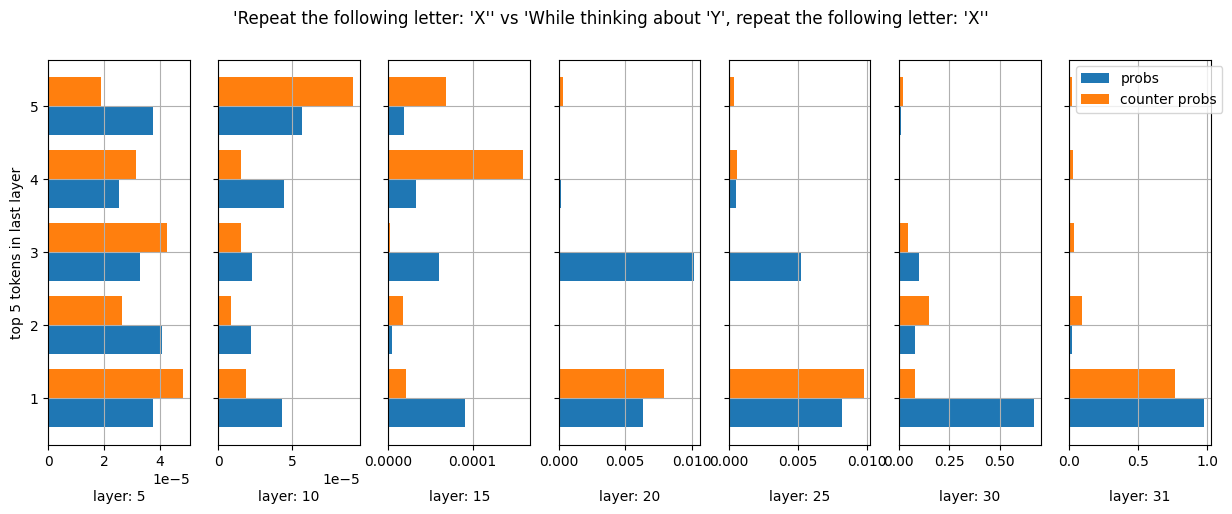

Say 'X' - top k: ['(', '[', 'Sure', 'I', '(']
Think 'Y' but say 'X' - top k: ['In', 'Our', 'When', 'To', 'For']


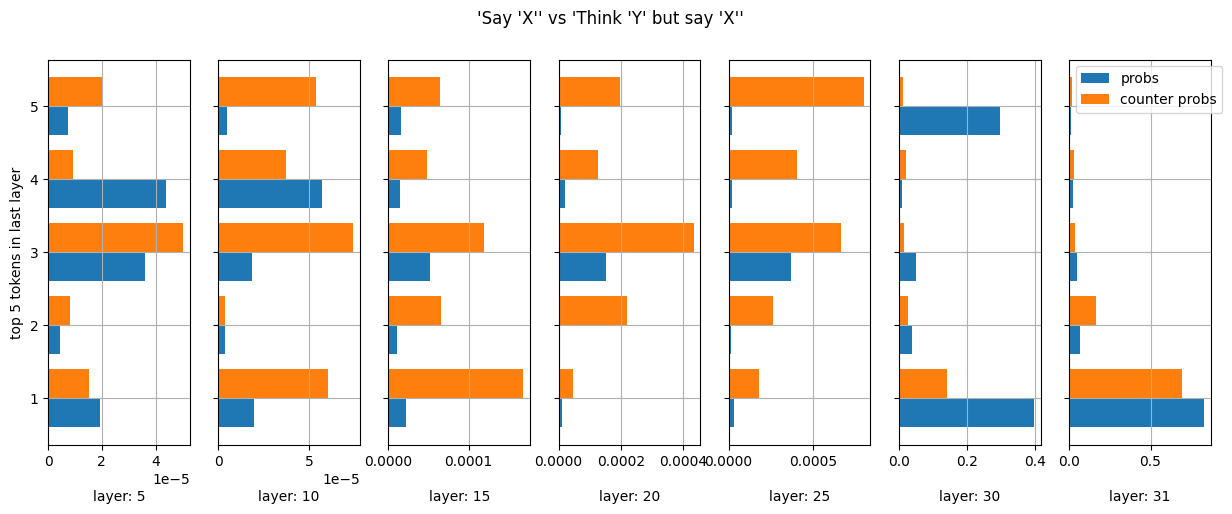

In [132]:
selected_layers = [5, 10, 15, 20, 25, 30, 31]
for i in range(data['top_k_prob'].shape[-1]):
    s=data['sentences'][i]
    c=data['counter_sentences'][i]
    s_k = data['top_k_tokens'][i]
    c_k = data['counter_top_k_tokens'][i]
    print(f'{s} - top k: {s_k}')
    print(f'{c} - top k: {c_k}')
    plot_top_k_prob(data['top_k_prob'][:,:,i], data['counter_top_k_prob'][:,:,i], selected_layers=selected_layers, k=k, title= f'\'{s}\' vs \'{c}\'')